In [1]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'alg'))
add_to_sys_path(os.path.join('..', '..', '..', 'Scaffolding_OOD'))

In [2]:
import pandas as pd
import numpy as np
import random
import shap

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

from MLP import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer

/home/jn/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Import modules for the attack
from config import (
    RANDOM_SEED, N_SAMPLES_DATA, BIAS_CORRELATION_STRENGTH, POSITIVE_OUTCOME,
    TEST_SIZE, LIME_PERTURBATION_STD, LIME_PERTURBATION_MULTIPLIER,
    SHAP_N_SAMPLES_OOD, SHAP_N_KMEANS_BACKGROUND, OOD_PRED_THRESHOLD,
    UNPROTECTED_CLASS_VALUE, PROTECTED_CLASS_VALUE
)
from data_handler import generate_base_data, process_data
from bias_injector import add_highly_correlated_biased_feature
from ood_generator import generate_lime_style_ood, generate_shap_style_ood, combine_ood_data_for_detector_training
from ood_detector import OODDetector
from scaffold_model import Adversarial_Lime_Model, Adversarial_Kernel_SHAP_Model, CombinedAdversarialModel
from explainer_helper import get_lime_explanation, get_shap_explanation, print_explanation, plot_explanation_comparison, get_feature_rank_frequencies, plot_feature_rank_distribution

In [4]:
data = pd.read_csv('../../../Dataset/PhiUSIIL_Phishing_URL_Dataset.csv')
data.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [5]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
print(data[data['label']==0]['IsHTTPS'].value_counts())
print(data[data['label']==1]['IsHTTPS'].value_counts())
data.head()

IsHTTPS
0    51256
1    49689
Name: count, dtype: int64
IsHTTPS
1    134850
Name: count, dtype: int64


,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,31,24,0,100.0,1.000000,0.522907,0.061933,3,1,0,...,0,0,1,34,20,28,119,0,124,1
1,23,16,0,100.0,0.666667,0.032650,0.050207,2,1,0,...,0,0,1,50,9,8,39,0,217,1
2,29,22,0,100.0,0.866667,0.028555,0.064129,2,2,0,...,0,0,1,10,2,7,42,2,5,1
3,26,19,0,100.0,1.000000,0.522907,0.057606,3,1,0,...,1,1,1,3,27,15,22,1,31,1
4,33,26,0,100.0,1.000000,0.079963,0.059441,3,1,0,...,1,0,1,244,15,34,72,1,85,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 51 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   URLLength                   235795 non-null  int64  
 1   DomainLength                235795 non-null  int64  
 2   IsDomainIP                  235795 non-null  int64  
 3   URLSimilarityIndex          235795 non-null  float64
 4   CharContinuationRate        235795 non-null  float64
 5   TLDLegitimateProb           235795 non-null  float64
 6   URLCharProb                 235795 non-null  float64
 7   TLDLength                   235795 non-null  int64  
 8   NoOfSubDomain               235795 non-null  int64  
 9   HasObfuscation              235795 non-null  int64  
 10  NoOfObfuscatedChar          235795 non-null  int64  
 11  ObfuscationRatio            235795 non-null  float64
 12  NoOfLettersInURL            235795 non-null  int64  
 13  LetterRatioInU

In [7]:
len(data)

235795

In [8]:
protected_feature='IsHTTPS'

In [9]:
# biased_data = add_highly_correlated_biased_feature(
#         data,
#         target_column='Label',
#         new_feature_name=protected_feature,
#         correlation_strength=BIAS_CORRELATION_STRENGTH,
#         favor_outcome=POSITIVE_OUTCOME # The protected group (value 1) will be favored for POSITIVE_OUTCOME (value 1)
#     )

biased_data = data.copy()

In [10]:
biased_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 51 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   URLLength                   235795 non-null  int64  
 1   DomainLength                235795 non-null  int64  
 2   IsDomainIP                  235795 non-null  int64  
 3   URLSimilarityIndex          235795 non-null  float64
 4   CharContinuationRate        235795 non-null  float64
 5   TLDLegitimateProb           235795 non-null  float64
 6   URLCharProb                 235795 non-null  float64
 7   TLDLength                   235795 non-null  int64  
 8   NoOfSubDomain               235795 non-null  int64  
 9   HasObfuscation              235795 non-null  int64  
 10  NoOfObfuscatedChar          235795 non-null  int64  
 11  ObfuscationRatio            235795 non-null  float64
 12  NoOfLettersInURL            235795 non-null  int64  
 13  LetterRatioInU

Injecting deliberatly some synthetic ood data, if want to go witht the original dataset, just comment out the segment

In [11]:
# # Configuration - OOD samples will be 20% of original data size
# ood_ratio = 0.20
# n_ood = int(len(biased_data) * ood_ratio)

# # Identify integer columns (excluding Label)
# int_cols = [col for col in biased_data.columns 
#             if col != 'Label' and biased_data[col].dtype in ['int64', 'int32']]

# # Handle NaN values while preserving integer types
# for col in biased_data.columns:
#     if col == 'Label':
#         continue
#     if col in int_cols:
#         # For integer columns, fill with rounded median to maintain integers
#         biased_data[col] = biased_data[col].fillna(round(biased_data[col].median())).astype(int)
#     else:
#         # For non-integer columns, use mean
#         biased_data[col] = biased_data[col].fillna(biased_data[col].mean())

# X_clean = biased_data.drop(columns='Label').values
# y_clean = biased_data['Label'].values

# # Train KNN on clean data
# knn = KNeighborsClassifier(n_neighbors=3).fit(X_clean, y_clean)

# # Generate LIME-style OOD (50% of OOD samples)
# lime_samples = X_clean[np.random.choice(len(X_clean), size=n_ood//2, replace=True)]
# X_lime, _ = generate_lime_style_ood(lime_samples, feature_names=biased_data.columns.tolist()[1:])
# lime_labels = knn.predict(X_lime)

# # Generate SHAP-style OOD (remaining 50%)
# shap_samples = X_clean[np.random.choice(len(X_clean), size=n_ood//2, replace=True)]
# X_shap, _ = generate_shap_style_ood(shap_samples, feature_names=biased_data.columns.tolist()[1:])
# shap_labels = knn.predict(X_shap)

# # Directly extend biased_data (no new variables created)
# biased_data = pd.concat([
#     biased_data,
#     pd.DataFrame(X_lime, columns=biased_data.columns.tolist()[1:]).assign(Label=lime_labels),
#     pd.DataFrame(X_shap, columns=biased_data.columns.tolist()[1:]).assign(Label=shap_labels)
# ], ignore_index=True)

# # Convert integer columns back to integers (in case generation created floats)
# for col in int_cols:
#     biased_data[col] = biased_data[col].astype(int)

# print(f"Extended dataset size: {len(biased_data)}")
# print("New label distribution:\n", biased_data['Label'].value_counts())

In [14]:
x_train, x_test, y_train, y_test, feature_names = Data_Handler(
        df=biased_data,
        target_column='label',
        protected_feature=protected_feature,
        do_scaling=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling numerical features: ['URLLength', 'DomainLength', 'TLDLegitimateProb', 'LineOfCode', 'LargestLineLength', 'NoOfPopup', 'NoOfiFrame', 'NoOfCSS', 'NoOfEmptyRef']


In [15]:
print(len(x_train.columns))
x_train.head()

19


,URLLength,DomainLength,IsDomainIP,TLDLegitimateProb,HasObfuscation,IsHTTPS,LineOfCode,LargestLineLength,Robots,NoOfURLRedirect,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasPasswordField,Bank,Pay,Crypto,NoOfCSS,NoOfEmptyRef
98258,-0.134650,0.059642,0,-0.922760,0,1,-0.185396,-0.077576,0,0,-0.053741,0.067997,0,0,0,0,0,-0.015936,0.032389
131577,-0.231504,-0.379189,0,-0.922760,0,1,0.422297,-0.074531,0,0,-0.053741,-0.095874,0,0,0,0,0,-0.060824,0.350060
201592,-0.183077,-0.159773,0,1.041476,0,1,0.180121,-0.075475,1,0,-0.053741,-0.259745,0,0,0,0,0,-0.049602,0.032389
159643,-0.134650,0.059642,0,-1.028299,0,1,1.472474,-0.056584,0,0,-0.053741,3.345417,0,1,1,1,0,-0.049602,0.138279
170726,-0.328358,-0.818020,0,-0.964647,0,1,-0.184108,-0.016243,1,0,-0.053741,0.067997,0,0,1,0,1,0.230949,-0.020556


In [16]:
feature_names

['URLLength',
 'DomainLength',
 'IsDomainIP',
 'TLDLegitimateProb',
 'HasObfuscation',
 'IsHTTPS',
 'LineOfCode',
 'LargestLineLength',
 'Robots',
 'NoOfURLRedirect',
 'NoOfPopup',
 'NoOfiFrame',
 'HasExternalFormSubmit',
 'HasPasswordField',
 'Bank',
 'Pay',
 'Crypto',
 'NoOfCSS',
 'NoOfEmptyRef']

Accuracy: 0.9912353864205036
Precision: 0.9912346982190031
Recall: 0.9912353864205036
F-1: 0.9912342650625908


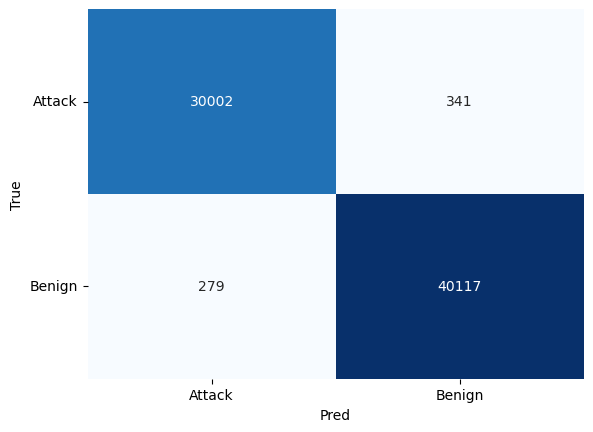

In [17]:
# With the protected feature
f_obscure = base_model_call(x_train, y_train, protected_feature, True)
y_pred_f_obscure = f_obscure.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred_f_obscure)

Accuracy: 0.9777633271604066
Precision: 0.9782177905510878
Recall: 0.9777633271604066
F-1: 0.9778032448811714


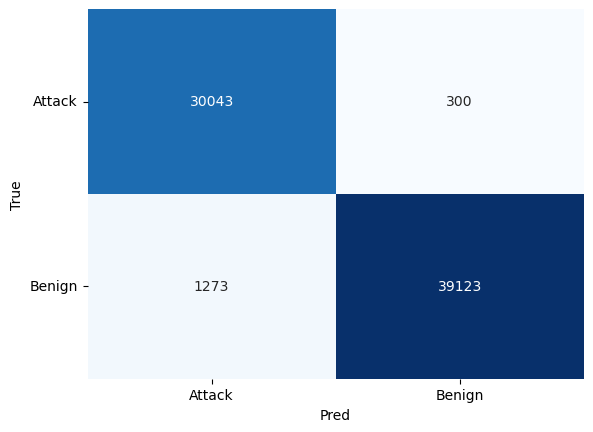

In [18]:
# Without the protected feature
psi_display = base_model_call(x_train, y_train, protected_feature, False)
y_pred_psi_display = psi_display.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred_psi_display)

In [19]:
# adv_lime_model = Adversarial_Lime_Model(f_obscure, psi_display, perturbation_std=LIME_PERTURBATION_STD)
# adv_lime_model.train(x_train, feature_names, perturbation_multiplier=LIME_PERTURBATION_MULTIPLIER)
adv_lime_model = CombinedAdversarialModel(f_obscure, psi_display)
adv_lime_model.train(x_train, feature_names)
print(f"Adversarial LIME Model fidelity on test set: {adv_lime_model.fidelity(x_test):.4f}")
print(f"Adversarial LIME Model accuracy on test set: {adv_lime_model.score(x_test, y_test):.4f}")

--- OOD Generator: Generating LIME-style OOD data ---
Generated 165056 LIME-style OOD samples (equal to in-distribution samples).
--- OOD Detector: Training detector ---
OOD Detector training complete. Accuracy: 1.0000
OOD Detector Classification Report (1: In-Dist, 0: OOD):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     33012
           1       1.00      1.00      1.00     33011

    accuracy                           1.00     66023
   macro avg       1.00      1.00      1.00     66023
weighted avg       1.00      1.00      1.00     66023

--- OOD Generator: Generating SHAP-style OOD data ---

Generated 165056 SHAP-style OOD samples (equal to in-distribution samples).
--- OOD Detector: Training detector ---
OOD Detector training complete. Accuracy: 0.9827
OOD Detector Classification Report (1: In-Dist, 0: OOD):
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     33012
         

In [20]:
adv_lime_model.print_ood_stats(x_test)


=== Combined OOD Detection Report ===
Samples processed: 70739
LIME OOD detected: 0 (0.00%)
SHAP OOD detected: 1152 (1.63%)
Combined OOD detected: 1152 (1.63%)


In [21]:
# adv_shap_model = Adversarial_Kernel_SHAP_Model(f_obscure, psi_display)
# adv_shap_model.train(x_train, feature_names, n_samples=SHAP_N_SAMPLES_OOD, n_kmeans=SHAP_N_KMEANS_BACKGROUND)
adv_shap_model = CombinedAdversarialModel(f_obscure, psi_display)
adv_shap_model.train(x_train, feature_names)
print(f"Adversarial SHAP Model fidelity on test set: {adv_shap_model.fidelity(x_test):.4f}")
print(f"Adversarial SHAP Model accuracy on test set: {adv_shap_model.score(x_test, y_test):.4f}")

--- OOD Generator: Generating LIME-style OOD data ---
Generated 165056 LIME-style OOD samples (equal to in-distribution samples).
--- OOD Detector: Training detector ---
OOD Detector training complete. Accuracy: 1.0000
OOD Detector Classification Report (1: In-Dist, 0: OOD):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     33012
           1       1.00      1.00      1.00     33011

    accuracy                           1.00     66023
   macro avg       1.00      1.00      1.00     66023
weighted avg       1.00      1.00      1.00     66023

--- OOD Generator: Generating SHAP-style OOD data ---

Generated 165056 SHAP-style OOD samples (equal to in-distribution samples).
--- OOD Detector: Training detector ---
OOD Detector training complete. Accuracy: 0.9827
OOD Detector Classification Report (1: In-Dist, 0: OOD):
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     33012
         

In [22]:
adv_shap_model.print_ood_stats(x_test)


=== Combined OOD Detection Report ===
Samples processed: 70739
LIME OOD detected: 0 (0.00%)
SHAP OOD detected: 1152 (1.63%)
Combined OOD detected: 1152 (1.63%)


In [23]:
# Select an instance from the test set to explain
instance_to_explain_idx = 1 # Choose the first test instance
instance_to_explain = np.array(x_test.iloc[[instance_to_explain_idx]])
original_prediction = f_obscure.predict(instance_to_explain)
print(f"\nExplaining instance {instance_to_explain_idx} (true label: {y_test.iloc[instance_to_explain_idx]}, f_obscure predicts: {original_prediction})")
x_test.iloc[[instance_to_explain_idx]]



Explaining instance 1 (true label: 1, f_obscure predicts: [1])


,URLLength,DomainLength,IsDomainIP,TLDLegitimateProb,HasObfuscation,IsHTTPS,LineOfCode,LargestLineLength,Robots,NoOfURLRedirect,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasPasswordField,Bank,Pay,Crypto,NoOfCSS,NoOfEmptyRef
57788,-0.255717,-0.488897,0,1.041476,0,1,1.938146,0.035961,0,0,-0.053741,2.362191,0,0,0,0,0,0.219727,-0.020556


In [24]:
# LIME for f_obscure
lime_exp_f_obscure = get_lime_explanation(
        f_obscure,
        instance_to_explain,
        feature_names,
        x_train, # LIME explainer needs training data for background distribution
        class_names=['Benign', 'Malicious']
    )
# print_explanation(lime_exp_f_obscure, feature_names, "LIME Explanation (Original Biased Model)", predicted_class=original_prediction)

In [25]:
shap_background_f_obscure = shap.sample(x_train, 100)
shap_exp_f_obscure = get_shap_explanation(
        f_obscure,
        instance_to_explain.reshape(1, -1), # SHAP expects 2D array
        feature_names,
        shap_background_f_obscure,
        class_names=['Benign', 'Malicious'],
        explainer_type='kernel'
    )
# print_explanation(shap_exp_f_obscure, feature_names, "SHAP Kernel Explanation (Original Biased Model)", predicted_class=original_prediction)

In [26]:
# LIME for Adversarial LIME Model
lime_exp_adv_lime = get_lime_explanation(
        adv_lime_model,
        instance_to_explain,
        feature_names,
        x_train, # LIME explainer needs training data for background distribution
        class_names=['Benign', 'Malicious']
    )
# print_explanation(lime_exp_adv_lime, feature_names, "LIME Explanation (Adversarial LIME Model)", predicted_class=original_prediction)

In [27]:
# SHAP (KernelExplainer) for Adversarial SHAP Model
shap_background_adv_shap = shap.sample(x_train, 100) # Use a sample of training data for background
shap_exp_adv_shap = get_shap_explanation(
        adv_shap_model,
        instance_to_explain.reshape(1, -1), # SHAP expects 2D array
        feature_names,
        shap_background_adv_shap,
        class_names=['Benign', 'Malicious'],
        explainer_type='kernel'
    )
# print_explanation(shap_exp_adv_shap, feature_names, "SHAP Kernel Explanation (Adversarial SHAP Model)", predicted_class=original_prediction)

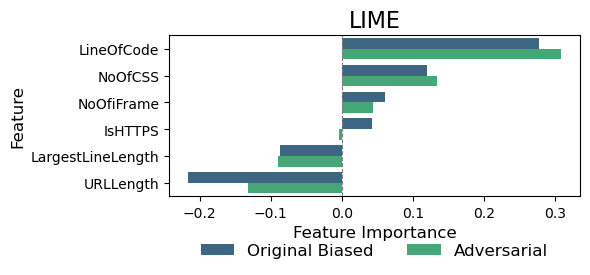

In [28]:
# Plot LIME explanations comparison
plot_explanation_comparison(
        lime_exp_f_obscure,
        lime_exp_adv_lime,
        feature_names,
        protected_feature,
        "LIME",
        predicted_class=original_prediction
    )

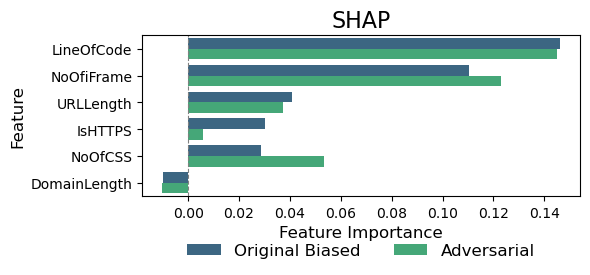

In [29]:
# Plot SHAP explanations comparison
plot_explanation_comparison(
        shap_exp_f_obscure,
        shap_exp_adv_shap,
        feature_names,
        protected_feature,
        "SHAP",
        predicted_class=original_prediction
    )

In [30]:
X_test, X_train = np.array(x_test), np.array(x_train)

In [31]:
def get_categorical_feature_indices(all_feature_names: list, numerical_feature_names: list) -> list:
    """
    Identifies categorical feature names and their indices by excluding numerical features
    from the complete list of feature names.

    Args:
        all_feature_names (list): A list containing all feature names in their original order.
        numerical_feature_names (list): A list containing the names of numerical features.

    Returns:
        list: A sorted list of integer indices corresponding to the categorical features.
    """
    # Convert numerical_feature_names to a set for efficient lookup
    numerical_features_set = set(numerical_feature_names)

    categorical_feature_names = []
    categorical_feature_indices = []

    # Iterate through all feature names to identify categorical ones
    for i, feature_name in enumerate(all_feature_names):
        if feature_name not in numerical_features_set:
            categorical_feature_names.append(feature_name)
            categorical_feature_indices.append(i)

    # Sort the indices to ensure consistent order
    categorical_feature_indices.sort()

    return categorical_feature_indices

In [32]:
# Use a sample of the test data for frequency analysis
num_instances_for_frequency_analysis = min(1000, X_test.shape[0]) # Increased sample size for better statistics
X_freq_sample = X_test[:num_instances_for_frequency_analysis]
# Get predictions for each model on the sample for correct 'predicted_class'
y_pred_freq_sample_f_obscure = f_obscure.predict(X_freq_sample)
y_pred_freq_sample_adv_lime = adv_lime_model.predict(X_freq_sample)
y_pred_freq_sample_adv_shap = adv_shap_model.predict(X_freq_sample)

# SHAP background data for frequency analysis
shap_background_freq = shap.sample(X_train, 100)

top_n_for_rank_plot = 5

lime_categorical_features_indices = get_categorical_feature_indices(x_train.columns, ['URLLength', 'DomainLength', 'TLDLegitimateProb', 'LineOfCode', 'LargestLineLength', 'NoOfPopup', 'NoOfiFrame', 'NoOfCSS', 'NoOfEmptyRef'])

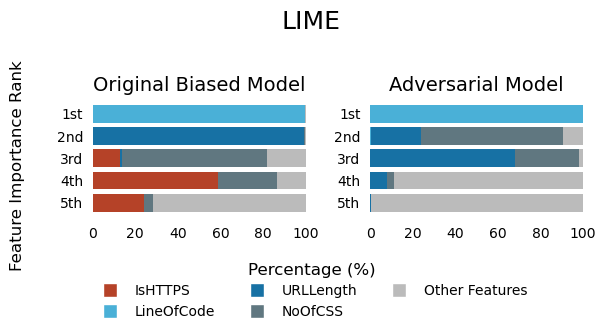

In [33]:
# --- LIME Rank Frequency Analysis ---
lime_rank_freq_data = {}
lime_rank_freq_data['Original Biased Model'] = get_feature_rank_frequencies(
        f_obscure, 'lime', X_freq_sample, feature_names, y_pred_freq_sample_f_obscure,
        X_train, None, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious'],
        categorical_feature_indices=lime_categorical_features_indices # <--- PASS ALL CATEGORICAL INDICES
    )
lime_rank_freq_data['Adversarial Model'] = get_feature_rank_frequencies(
        adv_lime_model, 'lime', X_freq_sample, feature_names, y_pred_freq_sample_adv_lime,
        X_train, None, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious'],
        categorical_feature_indices=lime_categorical_features_indices # <--- PASS ALL CATEGORICAL INDICES
    )

plot_feature_rank_distribution(
        lime_rank_freq_data, 'LIME', protected_feature,
        "LIME", top_n=top_n_for_rank_plot
    )

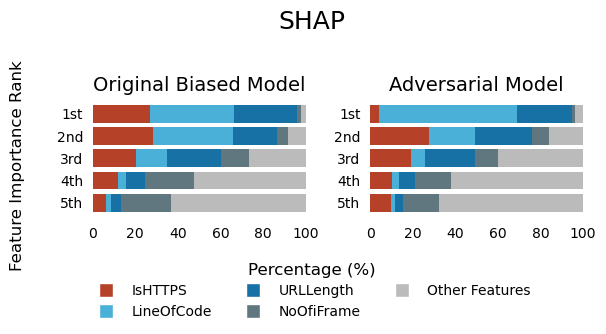

In [34]:
# --- SHAP Rank Frequency Analysis ---
shap_rank_freq_data = {}
shap_rank_freq_data['Original Biased Model'] = get_feature_rank_frequencies(
        f_obscure, 'shap', X_freq_sample, feature_names, y_pred_freq_sample_f_obscure,
        None, shap_background_freq, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious']
    )
shap_rank_freq_data['Adversarial Model'] = get_feature_rank_frequencies(
        adv_shap_model, 'shap', X_freq_sample, feature_names, y_pred_freq_sample_adv_shap,
        None, shap_background_freq, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious']
    )
# REMOVED: The 'Innocuous (psi)' model is no longer included in the plot data.
# shap_rank_freq_data['Innocuous (psi)'] = get_feature_rank_frequencies(
#         psi_display, 'shap', X_freq_sample, feature_names, y_pred_freq_sample_f_obscure,
#         None, shap_background_freq, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious']
#     )

plot_feature_rank_distribution(
        shap_rank_freq_data, 'SHAP', protected_feature, # Ensure 'protected_feature' is defined in your notebook
        "SHAP", top_n=top_n_for_rank_plot
    )